In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [66]:
df_weather = pd.read_csv('county_level_weather.csv')
df_weather.head()

,Unnamed: 0,County,Var,Year,January,February,March,April,May,June,July,August,September,October,November,December
0,0,Sierra,ppt,1980,415.709686,382.501617,111.128197,79.320557,64.565422,22.852375,17.899927,5.491146,9.450271,33.582626,41.988926,120.442238
1,1,Sierra,ppt,1981,236.459885,113.850082,176.456726,44.330055,63.482513,3.611892,0.004392,0.003986,30.670328,174.779312,504.357941,377.453613
2,2,Sierra,ppt,1982,229.290253,221.140564,298.874725,318.278595,11.199191,37.534851,13.221622,5.106486,111.741684,202.075043,250.340317,253.627685
3,3,Sierra,ppt,1983,232.798508,369.659393,429.405151,169.349167,41.239933,30.229248,8.763040,30.967905,54.934071,91.135620,504.704224,429.239380
4,4,Sierra,ppt,1984,17.905682,185.402206,118.662277,81.836754,31.953772,41.990131,17.944529,9.015877,8.106352,103.931931,325.303803,62.782768


**Currently the data is quite hard to query because you have to query the Var column and then select each month. It would be a little easier if we had a column for ppt in January or VPDmax in March.**

In [0]:
#Plan: Make a bunch of series and then concat them all into a df

#List the months and variables
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
variables = df_weather['Var'].unique()

#List to store all the dfs
df_list = []

#Iterate through months
for month in months:
  
  #Filter to month
  df_month = df_weather[['County', 'Year','Var', month]]
  
  #Iterate through vars
  for var in variables:
    
    #Name column
    desired_name = month+ '_' + var
   
    #Filter to variables
    df_month_var = df_month.loc[df_month['Var'] == var].rename(columns = {month:month+ '_' + var}).drop(['Var'], axis = 1)
    
    #Append to list
    df_list.append(df_month_var)


**We have a list of all of our dfs. We now want to merge them on county and year. We can use [reduce()](https://book.pythontips.com/en/latest/map_filter.html) from functools to do a "rolling" computation.**

In [0]:
from functools import reduce
df_weather_merged = reduce(lambda  left,right: pd.merge(left,right,on=['County', 'Year'],
                                            how='outer'), df_list)

**Check out the result. This will be much easier to query!**

In [70]:
df_weather_merged.head()

,County,Year,January_ppt,January_tmax,January_tmin,January_tmean,January_vpdmax,January_vpdmin,February_ppt,February_tmax,February_tmin,February_tmean,February_vpdmax,February_vpdmin,March_ppt,March_tmax,March_tmin,March_tmean,March_vpdmax,March_vpdmin,April_ppt,April_tmax,April_tmin,April_tmean,April_vpdmax,April_vpdmin,May_ppt,May_tmax,May_tmin,May_tmean,May_vpdmax,May_vpdmin,June_ppt,June_tmax,June_tmin,June_tmean,June_vpdmax,June_vpdmin,July_ppt,July_tmax,July_tmin,July_tmean,July_vpdmax,July_vpdmin,August_ppt,August_tmax,August_tmin,August_tmean,August_vpdmax,August_vpdmin,September_ppt,September_tmax,September_tmin,September_tmean,September_vpdmax,September_vpdmin,October_ppt,October_tmax,October_tmin,October_tmean,October_vpdmax,October_vpdmin,November_ppt,November_tmax,November_tmin,November_tmean,November_vpdmax,November_vpdmin,December_ppt,December_tmax,December_tmin,December_tmean,December_vpdmax,December_vpdmin
0,Sierra,1980,415.709686,6.415811,-3.536688,1.439561,4.567096,0.900473,382.501617,8.022836,-2.534324,2.744257,5.629257,0.789730,111.128197,7.917772,-5.233783,1.341993,6.811284,0.682297,79.320557,13.614462,-1.097838,6.258314,10.897299,1.161824,64.565422,15.683310,0.992230,8.337770,11.865405,0.895135,22.852375,19.245747,3.274729,11.260235,17.064259,1.857500,17.899927,26.238316,8.823446,17.530876,27.083784,3.966961,5.491146,26.291409,7.511015,16.901215,26.967834,4.109053,9.450271,23.308172,5.381148,14.344664,22.066820,3.330068,33.582626,19.002371,2.778716,10.890538,18.790813,3.336960,41.988926,12.337703,-1.470270,5.433717,10.158244,1.870744,120.442238,9.734934,-2.962905,3.386014,7.433448,1.787973
1,Sierra,1981,236.459885,8.395609,-2.993514,2.701048,6.016489,1.165946,113.850082,8.561417,-4.455543,2.052938,6.531755,0.810541,176.456726,8.589664,-3.696690,2.446487,6.609324,0.625608,44.330055,15.086349,-0.506689,7.289832,12.669528,1.405135,63.482513,17.870880,2.478244,10.174561,14.247837,1.583581,3.611892,25.063646,7.333107,16.198380,26.455404,4.156149,0.004392,28.257565,7.969191,18.113373,30.818111,5.258446,0.003986,29.495882,9.242567,19.369221,34.532028,5.360677,30.670328,25.396759,5.445946,15.421350,26.011009,3.415271,174.779312,14.616889,-0.292500,7.162194,11.256150,1.253851,504.357941,9.719727,-0.623716,4.548007,6.220675,1.111013,377.453613,7.190676,-2.197568,2.496554,4.770134,0.884527
2,Sierra,1982,229.290253,3.619055,-7.895067,-2.138007,4.508716,0.764730,221.140564,7.794862,-4.801757,1.496554,5.964256,0.856622,298.874725,5.931688,-4.472634,0.729527,4.644662,0.493378,318.278595,9.859526,-3.423514,3.218006,8.250746,0.886622,11.199191,19.200678,2.442703,10.821689,16.439463,1.980878,37.534851,20.913446,4.078379,12.495912,16.954527,1.311554,13.221622,25.221491,7.598379,16.409931,23.902836,3.263716,5.106486,26.666210,8.076621,17.371418,25.862032,3.914392,111.741684,20.428988,4.299663,12.364326,17.916489,2.294729,202.075043,14.318782,0.560473,7.439631,10.204461,1.237770,250.340317,7.082770,-3.927905,1.577433,5.511013,0.724324,253.627685,4.673042,-6.284797,-0.805878,4.395406,0.615068
3,Sierra,1983,232.798508,7.183243,-4.538581,1.322331,5.768040,1.109189,369.659393,6.143716,-4.080744,1.031487,4.689865,0.672567,429.405151,5.728377,-3.414798,1.156790,3.593446,0.883919,169.349167,8.240340,-3.730946,2.254696,6.202703,0.910338,41.239933,17.409866,0.840338,9.125099,15.240196,2.710608,30.229248,21.372906,4.908716,13.140814,17.596886,2.231351,8.763040,23.608381,5.796889,14.702637,22.666622,2.862297,30.967905,25.138783,8.469391,16.804085,22.499729,2.858041,54.934071,23.404596,6.214055,14.809326,22.009392,2.949595,91.135620,17.815269,2.856553,10.335910,12.967708,1.684392,504.704224,6.938378,-2.210204,2.364088,4.500947,0.763649,429.239380,4.178243,-3.234460,0.471892,3.131824,0.621014
4,Sierra,1984,17.905682,8.866152,-4.531350,2.167399,7.160810,1.510743,185.402206,8.097907,-5.463446,1.317230,6.747838,1.062432,118.662277,12.030677,-2.222230,4.904224,8.955407,1.446283,81.836754,11.395063,-3.061217,4.166926,9.403650,1.212905,31.9537

**Next step is to introduce the yield data which was obtained in a seperate notebook. We want to join this to the weather data on county and year.**

In [71]:
df_yield = pd.read_csv('California Crop Yields.csv')

#Filter out the non-county rows
df_counties = df_yield[df_yield['County Code'] < 900].drop('Unnamed: 0', axis = 1)

#Inspect
df_counties.head()

,Year,Commodity Code,Crop Name,County Code,County,Harvested Acres,Yield per Acre,Production,Price per Unit,Unit,Total Value
0,1980,261999,ALMONDS ALL,7,Butte,31468.0,0.42,13217.0,3000.0,TONS,39651000.0
1,1980,261999,ALMONDS ALL,9,Calaveras,NaN,NaN,12.0,3600.0,TONS,43200.0
2,1980,261999,ALMONDS ALL,11,Colusa,14000.0,0.15,2100.0,2800.0,TONS,5880000.0
3,1980,261999,ALMONDS ALL,13,Contra Costa,2990.0,0.19,568.0,1440.0,TONS,818000.0
4,1980,261999,ALMONDS ALL,19,Fresno,23992.0,0.59,14200.0,3000.0,TONS,42600000.0


**Perform join.**

In [117]:
#Join on county and year fields. Use inner join b/c we want data that has BOTH
#yield and weather data
df_weather_yield = df_weather_merged.merge(df_counties, how = 'inner', on = ['County', 'Year'])

#Inspect
df_weather_yield.head()

,County,Year,January_ppt,January_tmax,January_tmin,January_tmean,January_vpdmax,January_vpdmin,February_ppt,February_tmax,February_tmin,February_tmean,February_vpdmax,February_vpdmin,March_ppt,March_tmax,March_tmin,March_tmean,March_vpdmax,March_vpdmin,April_ppt,April_tmax,April_tmin,April_tmean,April_vpdmax,April_vpdmin,May_ppt,May_tmax,May_tmin,May_tmean,May_vpdmax,May_vpdmin,June_ppt,June_tmax,June_tmin,June_tmean,June_vpdmax,June_vpdmin,July_ppt,July_tmax,...,July_vpdmin,August_ppt,August_tmax,August_tmin,August_tmean,August_vpdmax,August_vpdmin,September_ppt,September_tmax,September_tmin,September_tmean,September_vpdmax,September_vpdmin,October_ppt,October_tmax,October_tmin,October_tmean,October_vpdmax,October_vpdmin,November_ppt,November_tmax,November_tmin,November_tmean,November_vpdmax,November_vpdmin,December_ppt,December_tmax,December_tmin,December_tmean,December_vpdmax,December_vpdmin,Commodity Code,Crop Name,County Code,Harvested Acres,Yield per Acre,Production,Price per Unit,Unit,Total Value
0,Sacramento,1980,144.467880,12.737988,5.257718,8.997851,3.718322,0.380067,172.348358,16.217516,7.003625,11.610574,6.928455,0.664899,59.468250,17.866579,5.733356,11.799971,10.988392,1.250738,31.329731,21.813820,8.219395,15.016606,15.608727,1.912148,11.976777,25.166519,9.651276,17.408894,21.329199,2.242014,0.912081,27.752146,11.454227,19.603188,27.396648,3.934631,15.044765,33.226109,...,5.283423,0.0,31.901814,13.363755,22.632778,33.683151,3.687382,0.000000,29.950806,12.481747,21.216278,28.104429,2.586510,2.793892,27.311007,10.023418,18.667212,25.811546,2.178456,3.032283,20.150541,5.482752,12.816646,14.114425,1.312014,52.204903,13.482215,3.379866,8.431041,5.867652,0.580940,216299,GRAPES WINE,67,3350.0,8.00,26800.0,210.0,TONS,5628000.0
1,Sacramento,1980,144.467880,12.737988,5.257718,8.997851,3.718322,0.380067,172.348358,16.217516,7.003625,11.610574,6.928455,0.664899,59.468250,17.866579,5.733356,11.799971,10.988392,1.250738,31.329731,21.813820,8.219395,15.016606,15.608727,1.912148,11.976777,25.166519,9.651276,17.408894,21.329199,2.242014,0.912081,27.752146,11.454227,19.603188,27.396648,3.934631,15.044765,33.226109,...,5.283423,0.0,31.901814,13.363755,22.632778,33.683151,3.687382,0.000000,29.950806,12.481747,21.216278,28.104429,2.586510,2.793892,27.311007,10.023418,18.667212,25.811546,2.178456,3.032283,20.150541,5.482752,12.816646,14.114425,1.312014,52.204903,13.482215,3.379866,8.431041,5.867652,0.580940,263999,WALNUTS ENGLISH,67,410.0,0.90,369.0,951.0,TONS,351000.0
2,Sacramento,1980,144.467880,12.737988,5.257718,8.997851,3.718322,0.380067,172.348358,16.217516,7.003625,11.610574,6.928455,0.664899,59.468250,17.866579,5.733356,11.799971,10.988392,1.250738,31.329731,21.813820,8.219395,15.016606,15.608727,1.912148,11.976777,25.166519,9.651276,17.408894,21.329199,2.242014,0.912081,27.752146,11.454227,19.603188,27.396648,3.934631,15.044765,33.226109,...,5.283423,0.0,31.901814,13.363755,22.632778,33.683151,3.687382,0.000000,29.950806,12.481747,21.216278,28.104429,2.586510,2.793892,27.311007,10.023418,18.667212,25.811546,2.178456,3.032283,20.150541,5.482752,12.816646,14.114425,1.312014,52.204903,13.482215,3.379866,8.431041,5.867652,0.580940,378299,TOMATOES PROCESSING,67,8560.0,28.97,248000.0,48.0,TONS,11805000.0
3,Sacramento,1981,132.503296,12.433155,5.035637,8.734395,4.878793,0.624967,24.492683,16.945038,5.507786,11.226409,8.647316,0.762550,100.797523,17.332417,6.301610,11.817011,9.076510,1.053423,22.273756,23.055368,7.915167,15.485265,16.645231,1.482886,11.681477,27.654425,11.198589,19.426498,25.817116,2.826376,0.000000,34.325500,15.843218,25.084354,42.518917,5.894967,0.000000,34.755516,...,4.926377,0.0,33.399597,14.123021,23.761307,35.922150,3.411410,6.128726,30.764835,13.483758,22.124290,30.313221,2.590134,55.972904,23.656918,9.064226,16.360571,18.346979,1.604698,156.213425,18.630539,9.027248,13.828894,9.326442,1.325437,94.639305,13.234232,5.938120,9.586173,4.598120,0.765839,216299,GRAPES WINE,67,3350.0,6.99,23400.0,224.0,TONS,5242000.0

**In our model it will be important to consider the squares of some of our variables. We can add those columns now.**

In [0]:
#We don't want to square these!
unaltered_vars = ['Year','County','Commodity Code', 'Crop Name', 'County Code', 'Harvested Acres',
                 'Yield per Acre', 'Production', 'Price per Unit', 'Total Value',
                 'Unit']

for column in list(df_weather_yield.columns):
  
  if column in unaltered_vars:
    continue
    
  else:
    name = column
    new_name = column + '_2'
    
    df_weather_yield[new_name] = df_weather_yield.apply(lambda x: x[name]**2, axis = 1)

**Inspect output. Should be over 150 columns. The variables we didn't square are still there, they are just not displayed in this output.**

In [122]:
df_weather_yield.head()

,County,Year,January_ppt,January_tmax,January_tmin,January_tmean,January_vpdmax,January_vpdmin,February_ppt,February_tmax,February_tmin,February_tmean,February_vpdmax,February_vpdmin,March_ppt,March_tmax,March_tmin,March_tmean,March_vpdmax,March_vpdmin,April_ppt,April_tmax,April_tmin,April_tmean,April_vpdmax,April_vpdmin,May_ppt,May_tmax,May_tmin,May_tmean,May_vpdmax,May_vpdmin,June_ppt,June_tmax,June_tmin,June_tmean,June_vpdmax,June_vpdmin,July_ppt,July_tmax,...,June_tmin_2,June_tmean_2,June_vpdmax_2,June_vpdmin_2,July_ppt_2,July_tmax_2,July_tmin_2,July_tmean_2,July_vpdmax_2,July_vpdmin_2,August_ppt_2,August_tmax_2,August_tmin_2,August_tmean_2,August_vpdmax_2,August_vpdmin_2,September_ppt_2,September_tmax_2,September_tmin_2,September_tmean_2,September_vpdmax_2,September_vpdmin_2,October_ppt_2,October_tmax_2,October_tmin_2,October_tmean_2,October_vpdmax_2,October_vpdmin_2,November_ppt_2,November_tmax_2,November_tmin_2,November_tmean_2,November_vpdmax_2,November_vpdmin_2,December_ppt_2,December_tmax_2,December_tmin_2,December_tmean_2,December_vpdmax_2,December_vpdmin_2
0,Sacramento,1980,144.467880,12.737988,5.257718,8.997851,3.718322,0.380067,172.348358,16.217516,7.003625,11.610574,6.928455,0.664899,59.468250,17.866579,5.733356,11.799971,10.988392,1.250738,31.329731,21.813820,8.219395,15.016606,15.608727,1.912148,11.976777,25.166519,9.651276,17.408894,21.329199,2.242014,0.912081,27.752146,11.454227,19.603188,27.396648,3.934631,15.044765,33.226109,...,131.199326,384.284963,750.576344,15.481324,226.344939,1103.974289,230.452648,585.804278,1461.717499,27.914563,0.0,1017.725705,178.589954,512.242648,1134.554678,13.596789,0.000000,897.050760,155.794000,450.130456,789.858943,6.690035,7.805835,745.891079,100.468917,348.464786,666.235924,4.745669,9.194738,406.044315,30.060573,164.266405,199.216985,1.721379,2725.351861,181.770119,11.423492,71.082448,34.429339,0.337491
1,Sacramento,1980,144.467880,12.737988,5.257718,8.997851,3.718322,0.380067,172.348358,16.217516,7.003625,11.610574,6.928455,0.664899,59.468250,17.866579,5.733356,11.799971,10.988392,1.250738,31.329731,21.813820,8.219395,15.016606,15.608727,1.912148,11.976777,25.166519,9.651276,17.408894,21.329199,2.242014,0.912081,27.752146,11.454227,19.603188,27.396648,3.934631,15.044765,33.226109,...,131.199326,384.284963,750.576344,15.481324,226.344939,1103.974289,230.452648,585.804278,1461.717499,27.914563,0.0,1017.725705,178.589954,512.242648,1134.554678,13.596789,0.000000,897.050760,155.794000,450.130456,789.858943,6.690035,7.805835,745.891079,100.468917,348.464786,666.235924,4.745669,9.194738,406.044315,30.060573,164.266405,199.216985,1.721379,2725.351861,181.770119,11.423492,71.082448,34.429339,0.337491
2,Sacramento,1980,144.467880,12.737988,5.257718,8.997851,3.718322,0.380067,172.348358,16.217516,7.003625,11.610574,6.928455,0.664899,59.468250,17.866579,5.733356,11.799971,10.988392,1.250738,31.329731,21.813820,8.219395,15.016606,15.608727,1.912148,11.976777,25.166519,9.651276,17.408894,21.329199,2.242014,0.912081,27.752146,11.454227,19.603188,27.396648,3.934631,15.044765,33.226109,...,131.199326,384.284963,750.576344,15.481324,226.344939,1103.974289,230.452648,585.804278,1461.717499,27.914563,0.0,1017.725705,178.589954,512.242648,1134.554678,13.596789,0.000000,897.050760,155.794000,450.130456,789.858943,6.690035,7.805835,745.891079,100.468917,348.464786,666.235924,4.745669,9.194738,406.044315,30.060573,164.266405,199.216985,1.721379,2725.351861,181.770119,11.423492,71.082448,34.429339,0.337491
3,Sacramento,1981,132.503296,12.433155,5.035637,8.734395,4.878793,0.624967,24.492683,16.945038,5.507786,11.226409,8.647316,0.762550,100.797523,17.332417,6.301610,11.817011,9.076510,1.053423,22.273756,23.055368,7.915167,15.485265,16.645231,1.482886,11.681477,27.654425,11.198589,19.426498,25.817116,2.826376,0.000000,34.325500,15.843218,25.084354,42.518917,5.894967,0.000000,34.755516,...,251.007552,629.224836,1807.858310,34.750631,0.000000,1207.945896,198.443002,596.397142,1876.510665,24.269189,

**Now we are going to center all of our variables on their respective mean over the domain. Achieved by subtracting each column by its mean. We will groupby the crop name.**

In [123]:
#Groupby
df_means = df_weather_yield.groupby('Crop Name').mean()
df_means = df_means.reset_index()

#Inspect
df_means.head()

,Crop Name,Year,January_ppt,January_tmax,January_tmin,January_tmean,January_vpdmax,January_vpdmin,February_ppt,February_tmax,February_tmin,February_tmean,February_vpdmax,February_vpdmin,March_ppt,March_tmax,March_tmin,March_tmean,March_vpdmax,March_vpdmin,April_ppt,April_tmax,April_tmin,April_tmean,April_vpdmax,April_vpdmin,May_ppt,May_tmax,May_tmin,May_tmean,May_vpdmax,May_vpdmin,June_ppt,June_tmax,June_tmin,June_tmean,June_vpdmax,June_vpdmin,July_ppt,July_tmax,...,June_tmin_2,June_tmean_2,June_vpdmax_2,June_vpdmin_2,July_ppt_2,July_tmax_2,July_tmin_2,July_tmean_2,July_vpdmax_2,July_vpdmin_2,August_ppt_2,August_tmax_2,August_tmin_2,August_tmean_2,August_vpdmax_2,August_vpdmin_2,September_ppt_2,September_tmax_2,September_tmin_2,September_tmean_2,September_vpdmax_2,September_vpdmin_2,October_ppt_2,October_tmax_2,October_tmin_2,October_tmean_2,October_vpdmax_2,October_vpdmin_2,November_ppt_2,November_tmax_2,November_tmin_2,November_tmean_2,November_vpdmax_2,November_vpdmin_2,December_ppt_2,December_tmax_2,December_tmin_2,December_tmean_2,December_vpdmax_2,December_vpdmin_2
0,ALMONDS ALL,1997.301611,110.623265,12.389855,2.359652,7.374732,6.463695,0.807701,105.381114,14.947290,3.597087,9.272165,8.664804,0.901527,91.221750,17.556253,5.091729,11.323967,11.443267,1.106157,41.376073,20.872173,6.660087,13.766105,16.400804,1.619092,21.278350,25.351808,9.865464,17.608600,23.190183,2.640767,7.464915,29.880421,13.158620,21.519484,31.173985,4.026923,1.606138,33.243613,...,176.639553,467.487341,1003.638233,18.981253,17.787571,1110.177533,248.729537,601.755561,1435.286225,32.311108,20.131621,1077.764865,230.002628,575.241073,1363.213972,28.689724,350.777791,913.092668,175.693672,471.847583,1038.396307,21.914561,2014.436476,615.779842,91.173102,294.318698,499.520287,9.151880,8648.767436,298.139562,28.204027,125.371606,129.435364,1.969390,18495.355694,156.151558,9.165245,55.279907,50.872646,1.020680
1,BERRIES STRAWBERRIES FRESH MARKET,2012.107143,100.322906,15.219477,3.479510,9.349411,10.774583,1.693941,84.768581,16.040049,4.238574,10.139215,10.652272,1.216496,59.728613,18.634763,5.537899,12.086235,13.499642,1.405875,30.581226,20.307194,6.301575,13.304287,15.977921,1.547955,8.464031,23.353259,8.692928,16.022952,20.288459,2.200788,3.779797,27.248829,11.657746,19.453143,26.724051,3.266873,2.079187,29.824333,...,138.677926,382.509660,748.245812,11.740426,55.815223,895.652645,197.140488,482.478394,978.238152,19.418278,1.209101,896.338653,195.277394,481.222643,997.758906,19.545794,30.786648,820.122909,163.770104,428.179346,859.768231,16.061192,2253.107740,592.758670,98.297675,292.206801,491.576699,9.629280,2865.160028,366.508447,42.309446,162.554958,207.782580,4.217889,12724.726885,224.170827,16.209292,84.860604,118.146370,3.656070
2,GRAPES WINE,1999.517872,123.727600,13.070621,2.696191,7.883380,7.544411,1.085366,120.886228,14.835431,3.611339,9.223357,9.045732,1.072916,101.070670,17.147304,4.922591,11.034919,11.432616,1.255848,48.863188,19.877208,6.232437,13.054794,15.356698,1.696491,23.302282,23.871160,9.117594,16.494333,20.890985,2.573136,7.544652,28.144968,12.162638,20.153759,28.156031,3.920326,2.185305,31.360761,...,154.044093,414.969193,870.734894,22.811601,31.243053,997.284367,225.985541,541.871685,1233.455681,36.793398,64.037669,978.923919,217.591408,528.479421,1186.979046,33.855662,306.984038,846.770461,169.238360,441.977722,931.107594,24.727463,3251.448845,582.592154,91.679659,282.598332,469.246927,11.166280,11093.574026,305.153575,33.230127,132.254183,148.942284,3.409917,28471.989292,173.335186,12.799907,64.573750,69.432945,1.971803
3,LETTUCE HEAD,1999.721622,87.566227,15.608738,3.806065,9.707377,10.365337,1.595937,90.760115,16.671126,4.607283,10.639180,11.317144,1.518209,65.138574,19.078488,6.029765,12.554102,13.944582,1.736326,26.132809,21.593074,7.361891,14.477458,17.935490,2.261776,12.647051,24.870931,10.074899,17.472877,22.662051,3.225625,3.396863,28.781720,13.032788,20.907215,29.851439,4.759786,2.429105,31.506037,...,183.627083,454.7

**Next step is to center our data on the respective mean.**

In [0]:
#Make a deep copy of df_weather_yield to preserve the original
df_centered = df_weather_yield.copy(deep = True)

#Specify variables
variables = list(df_weather_yield.columns)
crops = df_weather_yield['Crop Name'].unique()

#List of variables we don't want to subtract mean from
unaltered_vars = ['County','Commodity Code', 'Crop Name', 'County Code', 'Harvested Acres',
                 'Yield per Acre', 'Production', 'Price per Unit', 'Total Value',
                 'Unit']


for crop in crops:

  for var in variables:
    
    if var in unaltered_vars:
      continue
      
    else:
      #Extract mean of variable for specific crop
      var_mean = df_means.loc[df_means['Crop Name'] == crop,var].values[0]
      
      #Subtract the mean from the original data
      result = df_weather_yield[df_weather_yield['Crop Name'] == crop][var] - var_mean
      
      #Save result in df_centered
      df_centered.loc[df_centered['Crop Name'] == crop, var] = result

**Now we can check out our centered data.**

In [125]:
df_centered.head()

,County,Year,January_ppt,January_tmax,January_tmin,January_tmean,January_vpdmax,January_vpdmin,February_ppt,February_tmax,February_tmin,February_tmean,February_vpdmax,February_vpdmin,March_ppt,March_tmax,March_tmin,March_tmean,March_vpdmax,March_vpdmin,April_ppt,April_tmax,April_tmin,April_tmean,April_vpdmax,April_vpdmin,May_ppt,May_tmax,May_tmin,May_tmean,May_vpdmax,May_vpdmin,June_ppt,June_tmax,June_tmin,June_tmean,June_vpdmax,June_vpdmin,July_ppt,July_tmax,...,June_tmin_2,June_tmean_2,June_vpdmax_2,June_vpdmin_2,July_ppt_2,July_tmax_2,July_tmin_2,July_tmean_2,July_vpdmax_2,July_vpdmin_2,August_ppt_2,August_tmax_2,August_tmin_2,August_tmean_2,August_vpdmax_2,August_vpdmin_2,September_ppt_2,September_tmax_2,September_tmin_2,September_tmean_2,September_vpdmax_2,September_vpdmin_2,October_ppt_2,October_tmax_2,October_tmin_2,October_tmean_2,October_vpdmax_2,October_vpdmin_2,November_ppt_2,November_tmax_2,November_tmin_2,November_tmean_2,November_vpdmax_2,November_vpdmin_2,December_ppt_2,December_tmax_2,December_tmin_2,December_tmean_2,December_vpdmax_2,December_vpdmin_2
0,Sacramento,-19.517872,20.740280,-0.332633,2.561527,1.114472,-3.826089,-0.705298,51.462131,1.382085,3.392286,2.387217,-2.117276,-0.408017,-41.602420,0.719275,0.810764,0.765052,-0.444225,-0.005109,-17.533457,1.936612,1.986958,1.961813,0.252028,0.215656,-11.325504,1.295359,0.533682,0.914561,0.438214,-0.331122,-6.632571,-0.392823,-0.708411,-0.550571,-0.759383,0.014305,12.859459,1.865348,...,-22.844766,-30.684230,-120.158550,-7.330277,195.101887,106.689922,4.467107,43.932593,228.261818,-8.878834,-64.037669,38.801787,-39.001454,-16.236773,-52.424368,-20.258873,-306.984038,50.280298,-13.444360,8.152734,-141.248651,-18.037428,-3243.643010,163.298925,8.789258,65.866454,196.988997,-6.420611,-11084.379289,100.890740,-3.169554,32.012222,50.274700,-1.688537,-25746.637431,8.434934,-1.376416,6.508699,-35.003605,-1.634312
1,Sacramento,-17.262755,17.726157,0.164066,2.818945,1.491524,-3.131157,-0.541901,49.176713,1.543933,3.497813,2.520898,-1.710047,-0.300709,-45.742728,0.838901,0.918844,0.878898,-0.070931,0.123972,-17.572201,1.728103,2.000793,1.864470,0.213417,0.355281,-13.506325,0.837967,0.423523,0.630775,-0.089689,-0.195641,-7.773872,-0.992160,-0.926748,-0.959418,-1.543831,0.194475,13.282301,1.100804,...,-26.239645,-44.216113,-130.106334,-1.435315,206.056114,64.311253,3.306273,26.892282,176.009472,-2.398048,-41.914675,1.702021,-34.677372,-27.063548,-103.675689,-14.574769,-456.194771,29.762071,-9.409133,3.552877,-165.595380,-15.246231,-2970.971595,155.874251,12.457005,66.165266,196.676917,-4.808660,-12475.524924,113.416519,0.938720,39.978805,68.925641,-0.554203,-23692.755932,21.278480,1.167434,13.080836,-21.964266,-0.994823
2,Sacramento,-16.895935,56.351026,-0.744106,1.972108,0.614020,-3.429407,-0.509383,86.803677,0.244839,2.453425,1.349156,-2.389781,-0.325616,-10.965807,-0.678268,-0.296797,-0.487509,-1.190495,0.007207,0.263073,0.065069,0.711473,0.388291,-1.566495,0.132719,-1.919114,-0.703158,-0.774210,-0.738654,-2.261346,-0.508504,-3.206749,-2.369750,-1.988975,-2.179327,-3.959550,-0.135714,13.874031,0.114802,...,-54.883373,-97.425852,-302.514588,-6.645920,211.838490,-1.799103,-23.129422,-17.513546,51.422811,-4.419598,-43.379646,-57.804454,-62.820584,-70.243244,-185.336823,-13.600371,-179.020621,-35.188106,-36.371920,-41.372953,-253.073070,-13.758346,-1072.982948,95.615702,-6.722957,28.292118,135.052709,-5.180663,-4076.683368,69.432048,-7.930564,16.026466,42.991311,-1.151721,-6827.537754,-5.773901,-2.560635,-0.701441,-32.732269,-1.199811
3,Sacramento,-18.517872,8.775696,-0.637466,2.339446,0.851015,-2.665618,-0.460399,-96.393544,2.109607,1.896446,2.003052,-0.398416,-0.310366,-0.273146,0.185112,1.379018,0.782092,-2.356106,-0.202424,-26.589432,3.178160,1.682730,2.430471,1.288533,-0.213605,-11.620805,3.783265,2.080995,2.932166,4.926131,0.253240,-7.544652,6.180532,3.680579,4.930596,14.362886,1.974640,-2.185305,3.394755,...,96.963459,214.255643,937.123416,11.939030,-31.243053,210.66

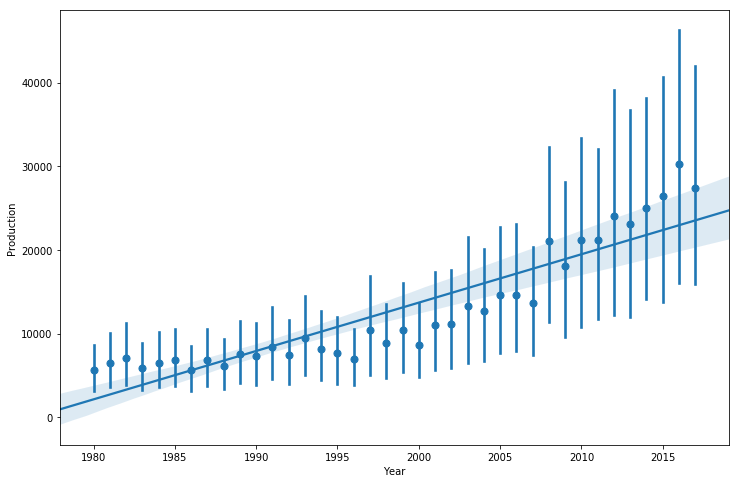

In [0]:
df_almonds = df_weather_yield[df_weather_yield['Crop Name'] == 'WALNUTS ENGLISH']

fig, ax = plt.subplots(figsize = (12,8))

ax = sns.regplot(x = 'Year', y = 'Production', data = df_almonds, x_estimator = np.mean)

In [0]:
df_almonds.sort_values(by = 'Production')

In [0]:
test[(test['County'] == 'Colusa') & (test['Year'] == 1980)]

,County,Year,January_ppt,January_tmax,January_tmin,January_tmean,January_vpdmax,January_vpdmin,February_ppt,February_tmax,February_tmin,February_tmean,February_vpdmax,February_vpdmin,March_ppt,March_tmax,March_tmin,March_tmean,March_vpdmax,March_vpdmin,April_ppt,April_tmax,April_tmin,April_tmean,April_vpdmax,April_vpdmin,May_ppt,May_tmax,May_tmin,May_tmean,May_vpdmax,May_vpdmin,June_ppt,June_tmax,June_tmin,June_tmean,June_vpdmax,June_vpdmin,July_ppt,July_tmax,...,July_vpdmin,August_ppt,August_tmax,August_tmin,August_tmean,August_vpdmax,August_vpdmin,September_ppt,September_tmax,September_tmin,September_tmean,September_vpdmax,September_vpdmin,October_ppt,October_tmax,October_tmin,October_tmean,October_vpdmax,October_vpdmin,November_ppt,November_tmax,November_tmin,November_tmean,November_vpdmax,November_vpdmin,December_ppt,December_tmax,December_tmin,December_tmean,December_vpdmax,December_vpdmin,Commodity Code,Crop Name,County Code,Harvested Acres,Yield per Acre,Production,Price per Unit,Unit,Total Value
2585,Colusa,1980,111.438026,13.252484,3.450001,8.351241,5.473333,0.459209,201.132309,14.954127,5.321694,10.137907,6.881582,0.578814,48.030682,16.858644,3.829887,10.344264,11.11299,1.013672,38.421249,21.232986,6.340338,13.786665,16.230452,1.294803,10.231582,24.898926,8.918757,16.908844,21.995369,1.981581,7.963563,27.329891,10.789943,19.059917,26.524061,2.794181,3.767233,33.452991,...,4.566552,0.0,32.401253,13.614682,23.007969,35.519836,4.090678,1.903108,30.3174,11.712998,21.015198,31.341257,3.603333,10.398471,26.893679,8.362316,17.627996,26.57762,2.381412,5.04825,19.205431,3.706835,11.456131,13.764854,1.128248,87.015015,14.306385,2.217966,8.262174,7.402089,0.659605,261999.0,ALMONDS ALL,11.0,14000.0,0.15,2100.0,2800.0,TONS,5880000.0
2586,Colusa,1980,111.438026,13.252484,3.450001,8.351241,5.473333,0.459209,201.132309,14.954127,5.321694,10.137907,6.881582,0.578814,48.030682,16.858644,3.829887,10.344264,11.11299,1.013672,38.421249,21.232986,6.340338,13.786665,16.230452,1.294803,10.231582,24.898926,8.918757,16.908844,21.995369,1.981581,7.963563,27.329891,10.789943,19.059917,26.524061,2.794181,3.767233,33.452991,...,4.566552,0.0,32.401253,13.614682,23.007969,35.519836,4.090678,1.903108,30.3174,11.712998,21.015198,31.341257,3.603333,10.398471,26.893679,8.362316,17.627996,26.57762,2.381412,5.04825,19.205431,3.706835,11.456131,13.764854,1.128248,87.015015,14.306385,2.217966,8.262174,7.402089,0.659605,263999.0,WALNUTS ENGLISH,11.0,6150.0,1.10,6765.0,950.0,TONS,6426800.0
2587,Colusa,1980,111.438026,13.252484,3.450001,8.351241,5.473333,0.459209,201.132309,14.954127,5.321694,10.137907,6.881582,0.578814,48.030682,16.858644,3.829887,10.344264,11.11299,1.013672,38.421249,21.232986,6.340338,13.786665,16.230452,1.294803,10.231582,24.898926,8.918757,16.908844,21.995369,1.981581,7.963563,27.329891,10.789943,19.059917,26.524061,2.794181,3.767233,33.452991,...,4.566552,0.0,32.401253,13.614682,23.007969,35.519836,4.090678,1.903108,30.3174,11.712998,21.015198,31.341257,3.603333,10.398471,26.893679,8.362316,17.627996,26.57762,2.381412,5.04825,19.205431,3.706835,11.456131,13.764854,1.128248,87.015015,14.306385,2.217966,8.262174,7.402089,0.659605,378299.0,TOMATOES PROCESSING,11.0,6060.0,26.73,162000.0,45.0,TONS,7274000.0


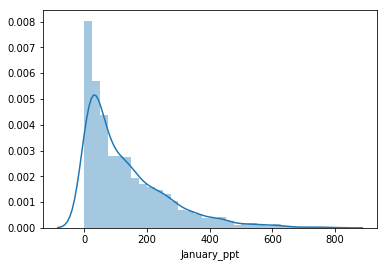

In [0]:
sns.distplot(df_month_var['January_ppt'])

**End editing session**

In [0]:
#Show average ppt in Los Angeles County from 1980 - 2017 as histogram in each January
row = df_weather.loc[(df_weather['County'] == 'Los Angeles') & (df_weather['Var'] == 'ppt')]
row = row['January']

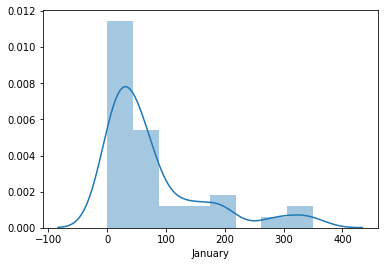

In [0]:
sns.distplot(row)

In [0]:
len(df_weather['Year'].unique())

38

In [0]:
df_yield = pd.read_csv('California Crop Yields.csv')
df_yield.head()

,Unnamed: 0,Year,Commodity Code,Crop Name,County Code,County,Harvested Acres,Yield per Acre,Production,Price per Unit,Unit,Total Value
0,0,1980,261999,ALMONDS ALL,7,Butte,31468.0,0.42,13217.0,3000.0,TONS,39651000.0
1,1,1980,261999,ALMONDS ALL,9,Calaveras,NaN,NaN,12.0,3600.0,TONS,43200.0
2,2,1980,261999,ALMONDS ALL,11,Colusa,14000.0,0.15,2100.0,2800.0,TONS,5880000.0
3,3,1980,261999,ALMONDS ALL,13,Contra Costa,2990.0,0.19,568.0,1440.0,TONS,818000.0
4,4,1980,261999,ALMONDS ALL,19,Fresno,23992.0,0.59,14200.0,3000.0,TONS,42600000.0


In [0]:
len(df_yield['Year'].unique())

38

In [0]:
booty = {'Gender':['Male', 'Female'],
       'Booty':['Not Thick', 'Thick']}

attendance = {'Name':['Bob','Jack','Julie','Sophia'],
             'Gender': ['Male','Male', 'Female', 'Female'],
             'Number':[100,300,400,500]}

df_booty = pd.DataFrame.from_dict(booty)
df_attendance = pd.DataFrame.from_dict(attendance) 


In [0]:
df_booty.head()

,Gender,Booty
0,Male,Not Thick
1,Female,Thick


In [0]:
df_attendance.head()

,Name,Gender
0,Bob,Male
1,Jack,Male
2,Julie,Female
3,Sophia,Female


In [0]:
df_attendance.merge(df_booty, on = 'Gender')

,Name,Gender,Number,Booty
0,Bob,Male,100,Not Thick
1,Jack,Male,300,Not Thick
2,Julie,Female,400,Thick
3,Sophia,Female,500,Thick


In [0]:
df_attendance.iloc[0,2] = df_attendance.iloc[0,2] - 4

In [0]:
df_attendance

,Name,Gender,Number
0,Bob,Male,96
1,Jack,Male,300
2,Julie,Female,400
3,Sophia,Female,500
